## Anomaly Detection in Water Usage

**Objective:** Detect anomalies or unusual spikes in water consumption in a particular year, industry, or county.

**Why:** Anomalies in water consumption can indicate either a reporting error or an event (e.g., drought, industry change) worth investigating.

In [6]:
import pandas as pd
import gradio as gr
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('water_use_data_2013_to_2022.csv')

# Select relevant features for anomaly detection
features = ['gallons_from_great_lakes', 'gallons_from_groundwater', 'gallons_from_inland_surface', 'total_gallons_all_sources']
X = data[features]

# Handle missing values (optional, depends on your data)
X = X.fillna(0)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


c:\Users\bharath kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Data Preparation**
The data preparation process involves several steps:

**county:** Name of the county

gallons_from_great_lakes, gallons_from_groundwater, gallons_from_inland_surface, 

**total_gallons_all_sources:** Water usage from different sources

**industry:** The industry using the water

**year:** The year of the data

We'll preprocess the dataset for anomaly detection

In [2]:
data.head()

,Unnamed: 0,county,gallons_from_great_lakes,gallons_from_groundwater,gallons_from_inland_surface,total_gallons_all_sources,industry,year
0,0,Alcona,0,2666085962,4695086047,7361172009,Total All Sectors,2014
1,1,Alger,1512160000,1608226431,799089999,3919476431,Total All Sectors,2014
2,2,Allegan,0,5552539983,3784550040,9337090023,Total All Sectors,2014
3,3,Alpena,40839120000,10948600250,2532270000,54319990250,Total All Sectors,2014
4,4,Antrim,0,12214548686,54526097,12269074783,Total All Sectors,2014


### One-Class SVM for Anomaly Detection

One-Class SVM (Support Vector Machine) is a machine learning algorithm designed for unsupervised anomaly detection. It is particularly useful when the dataset contains mostly normal data with a few anomalies. The algorithm tries to distinguish the normal instances from the anomalies by learning a decision boundary that tightly encloses the normal data points.

### How One-Class SVM Works:

**Training Phase:** One-Class SVM models are trained on normal data (in our case, water usage data from counties). The model learns a boundary that captures the majority of data points.

**Anomaly Detection:** After training, when the model is applied to new data, it classifies each data point as either normal or anomalous based on whether it falls inside or outside the learned boundary. Data points that lie outside this boundary are considered anomalies.

In [3]:
from sklearn.svm import OneClassSVM

# Train the One-Class SVM model
svm_model = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
data['anomaly_svm'] = svm_model.fit_predict(X_scaled)

# Anomalies are marked as -1
svm_anomalies = data[data['anomaly_svm'] == -1]

# Display SVM anomalies
print(svm_anomalies[['county', 'year', 'industry', 'total_gallons_all_sources', 'anomaly_svm']])

# Save the SVM anomalies to a CSV file
svm_anomalies.to_csv('svm_anomalies_water_usage.csv', index=False)
print("SVM anomaly detection results saved to 'svm_anomalies_water_usage.csv'")


       county  year             industry  total_gallons_all_sources  \
3      Alpena  2014    Total All Sectors                54319990250   
4      Antrim  2014    Total All Sectors                12269074783   
8         Bay  2014    Total All Sectors               216092249186   
10    Berrien  2014    Total All Sectors               791848178416   
13       Cass  2014    Total All Sectors                14040909058   
...       ...   ...                  ...                        ...   
6542  Tuscola  2020                Other                          0   
6546  Wexford  2020                Other                      63450   
6579   Ingham  2020  Public Water Supply                10671840674   
6609  Oakland  2020  Public Water Supply                 7975141709   
6628    Wayne  2020  Public Water Supply               161178737000   

      anomaly_svm  
3              -1  
4              -1  
8              -1  
10             -1  
13             -1  
...           ...  
6542   

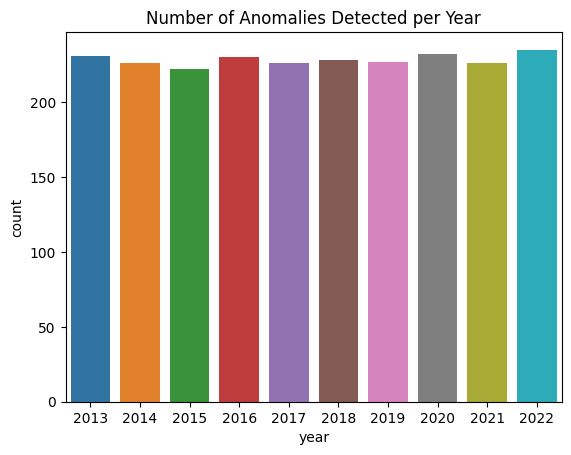

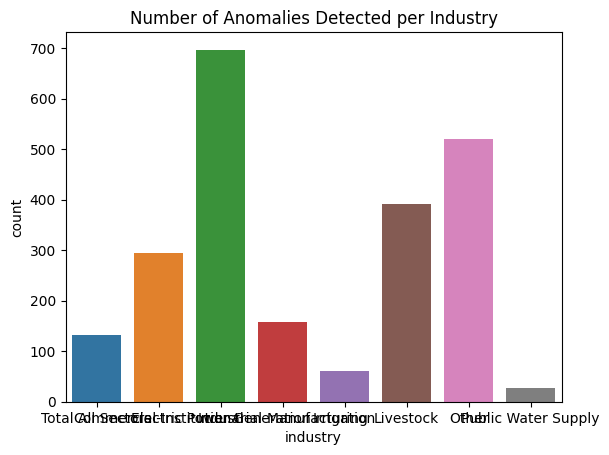

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot anomalies over the years
sns.countplot(x='year', data=svm_anomalies)
plt.title('Number of Anomalies Detected per Year')
plt.show()

# Plot anomalies per industry
sns.countplot(x='industry', data=svm_anomalies)
plt.title('Number of Anomalies Detected per Industry')
plt.show()


In [13]:

def detect_svm_anomalies(county, year):
    # Filter data based on the selected county and year
    selected_data = data[(data['county'] == county) & (data['year'] == year)]
    
    # Check if any anomalies are detected in the filtered data
    anomalies = selected_data[selected_data['anomaly_svm'] == -1]
    
    if len(anomalies) > 0:
        return f"Anomalies detected in {len(anomalies)} instances for {county} in {year}."
    else:
        return f"No anomalies detected for {county} in {year}."

# Convert the year column to int to avoid the int64 serialization issue
min_year = int(data['year'].min())
max_year = int(data['year'].max())

# Create the Gradio interface
interface = gr.Interface(
    fn=detect_svm_anomalies,
    inputs=[
        gr.Textbox(label="County Name"),
        gr.Slider(minimum=min_year, maximum=max_year, step=1, label="Year")
    ],
    outputs=gr.Textbox(label="Anomaly Detection Result"),
    title="Water Usage Anomaly Detection using One-Class SVM",
    description="Select a county and year to detect anomalies in water consumption based on One-Class SVM."
)

# Launch the Gradio interface
interface.launch()


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: true labels and predictions
true_labels = [1, 0, 0, 1, 1, 0]  # 1 for anomaly, 0 for normal
predictions = [1, 0, 0, 1, 0, 0]  # Model predictions

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
pip install 